# Packages & functions

In [69]:
env = 'pc'  # 'colab'

In [70]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/image_generator/'
    files = [
            'DataProperties.py',
            'DatasetParameters.py',
            'Preprocessing.py',
            'PreprocessingParameters.py',
            'Utils.py'
    ]
    url_dict = {file: path + file for file in files}
    download_files(url_dict)

In [71]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir

In [72]:
# Models
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Plotting
import seaborn as sns

# Utils
import importlib
from os.path import isdir

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [73]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils
import CNNModel
import BNModel
import DropoutModel

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing,
        CNNModel,
        BNModel,
        DropoutModel
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *
from CNNModel import CNNModel
from BNModel import BNModel
from DropoutModel import DropoutModel

In [74]:
DataProps = DataProperties(environment = env)

# Data download

## Paths download

In [75]:
assert isdir(DataProps.train_data_path) == True
assert isdir(DataProps.test_data_path) == True

In [76]:
train_covid_fnames, train_pn_fnames, train_normal_fnames = get_filenames(
    covid_path = DataProps.train_covid_path,
    pneumonia_path = DataProps.train_pneumonia_path,
    normal_path = DataProps.train_healthy_path
)

test_covid_fnames, test_pn_fnames, test_normal_fnames = get_filenames(
    covid_path = DataProps.test_covid_path,
    pneumonia_path = DataProps.test_pneumonia_path,
    normal_path = DataProps.test_healthy_path
)

In [77]:
train_covid_labels, train_pn_labels, train_normal_labels = get_labels(
    train_covid_fnames,
    train_pn_fnames,
    train_normal_fnames
)

test_covid_labels, test_pn_labels, test_normal_labels = get_labels(
    test_covid_fnames,
    test_pn_fnames,
    test_normal_fnames
)

In [78]:
X_train_val, Y_train_val = getXY(
    train_covid_fnames, train_pn_fnames, train_normal_fnames,
    train_covid_labels, train_pn_labels, train_normal_labels
)

X_test, Y_test = getXY(
    test_covid_fnames, test_pn_fnames, test_normal_fnames,
    test_covid_labels, test_pn_labels, test_normal_labels
)

# Data exploration

C:\Users\79137\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


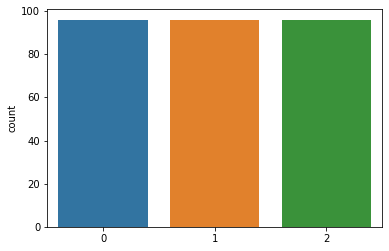

In [79]:
_ = sns.countplot(Y_test)

C:\Users\79137\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


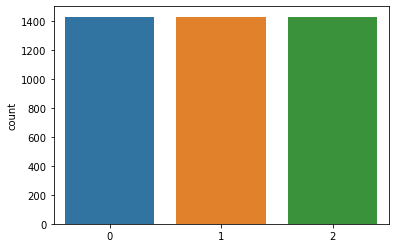

In [80]:
_ = sns.countplot(Y_train_val)

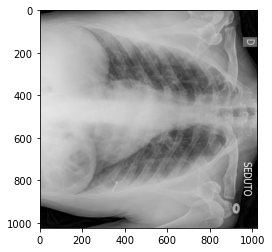

In [81]:
im = load_image(X_train_val[70])
plt.imshow(im.astype('uint8'))

# Creating dataset

In [82]:
def calc_necessary_split(desired_N, directory):
    total_files = 0

    for base, _, files in os.walk(directory):
        print('Searching in : ',base)
        for _ in files:
            total_files += 1
    print(f'Total files: {total_files}')
    return 1 - desired_N / total_files

# We want to use only little data in the beginning, to check if the code works fine
initial_N = 200
dummy_split = calc_necessary_split(
    initial_N,
    directory = DataProps.train_data_path
)
dummy_split

Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/
Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/covid
Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/normal
Searching in :  C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Data/TrainData/pneumonia
Total files: 4287


0.953347329134593

In [83]:
if DataProperties.strategy == 'check':
    split = dummy_split
elif DataProperties.strategy == 'normal':
    split = DatasetParameters.validation_split

train_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = split
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

train_flow = train_generator.flow_from_directory(
    directory = DataProps.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',
    shuffle = DatasetParameters.shuffle_train,
    seed = DatasetParameters.seed
)

val_flow = train_generator.flow_from_directory(
    directory = DataProps.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes, 
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'validation',
    shuffle = DatasetParameters.shuffle_validation,
    seed = DatasetParameters.seed
)

Found 201 images belonging to 3 classes.
Found 4086 images belonging to 3 classes.


In [84]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    # other parameters
)

test_flow = test_generator.flow_from_directory(
    directory = DataProps.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1
)

Found 288 images belonging to 3 classes.


In [85]:
assert train_flow.class_indices == test_flow.class_indices
assert train_flow.class_indices == val_flow.class_indices

# Visualizing dataset

(32, 300, 300, 3)


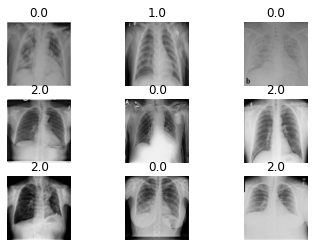

In [86]:
how_many_to_show = 9
for _ in range(1):
    batch, labels = train_flow.next()
    print(batch.shape)
    assert np.max(batch) <= 1.0
    visualize(batch, labels, how_many_to_show)

# Prepare before training

In [87]:
train_steps = train_flow.n // train_flow.batch_size
validation_steps = val_flow.n // val_flow.batch_size
test_steps = test_flow.n // test_flow.batch_size

if DataProperties.strategy == 'check':
    what_to_monitor = 'loss'
    validation_data = None
    validation_steps = None
elif DataProperties.strategy == 'normal':
    what_to_monitor = 'val_loss'
    validation_data = val_flow,
    validation_steps = validation_steps


callback = tf.keras.callbacks.EarlyStopping(
    monitor = what_to_monitor,
    patience = 2,  # 3
    mode = 'auto',
    restore_best_weights = True
)

print(f'Train steps: {train_steps}')
print(f'Val steps: {validation_steps}')

Train steps: 6
Val steps: None


# CNN architecture

In [90]:
cnn_model = CNNModel()
cnn_model.construct_model()
cnn_model.compile_model(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = [
        'accuracy'
        # tf.keras.metrics.SparseCategoricalAccuracy(),
        #tf.keras.metrics.Recall()
    ]
)
# print(cnn_model.model.summary())

In [95]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=DataProps.checkpoint_path + cnn_model.name + '/',
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only = True
)

In [96]:
history = cnn_model.model.fit(
    train_flow,
    steps_per_epoch = train_steps,
    
    validation_data = validation_data,
    validation_steps = validation_steps,

    epochs = 3,  # DatasetParameters.epochs,
    callbacks = [callback, model_checkpoint_callback]
)


Epoch 1/3
6/6 [==============================] - 8s 1s/step - loss: 0.6134 - acc: 0.6154
Epoch 2/3
6/6 [==============================] - 8s 1s/step - loss: 0.5579 - acc: 0.6719
Epoch 3/3
6/6 [==============================] - 6s 1s/step - loss: 0.5921 - acc: 0.6575


In [98]:
# cn_test = CNNModel()
# cn_test.construct_model()
# cn_test.compile_model(
#     optimizer = 'adam',
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
#     metrics = [
#         'accuracy'
#         # tf.keras.metrics.SparseCategoricalAccuracy(),
#         #tf.keras.metrics.Recall()
#     ]
# )

# model = cn_test.model
# model.load_weights(
#     DataProps.checkpoint_path + cn_test.name + '/',
# )
# model.evaluate(
#     val_flow,
#     steps = validation_steps
# )


In [44]:
cnn_model.model.evaluate(
    val_flow,
    steps = validation_steps
)

128/128 [==============================] - 79s 615ms/step - loss: 0.9757 - acc: 0.5729


[0.9757120772264898, 0.57293195]

In [50]:
test_flow.reset()
cnn_model.model.evaluate(
    test_flow,
    steps = test_steps
)

154/414 [==========>...................] - ETA: 1:30 - loss: 1.7739 - accuracy: 0.2013

KeyboardInterrupt: ignored

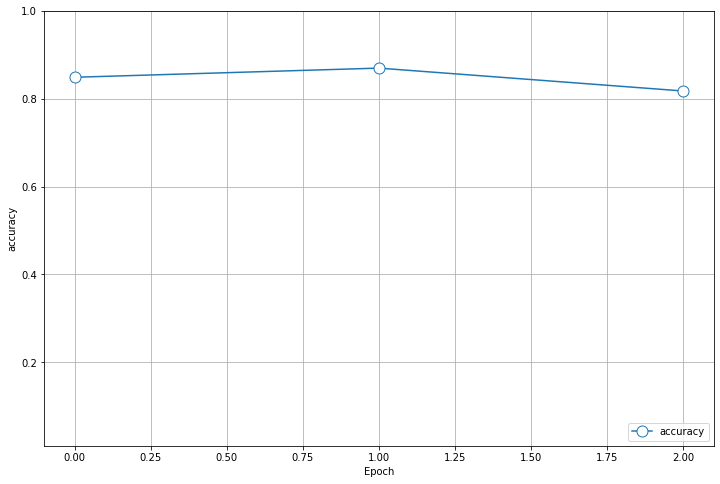

In [53]:
plot_history(
    history = history.history,
    metrics_name = 'accuracy',
    plot_validation = False
)

# Batch normalization

In [30]:
bn_model = BNModel()
bn_model.construct_model()
bn_model.compile_model(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

# print(cnn_model.model.summary())

In [33]:
bn_history = bn_model.model.fit(
    train_flow,
    steps_per_epoch = train_steps,
    
    validation_data = validation_data,
    validation_steps = validation_steps,

    epochs = 3, # DatasetParameters.epochs,
    callbacks = [callback]
)

Epoch 1/3
6/6 [==============================] - 32s 5s/step - loss: 0.0199 - acc: 0.9941
Epoch 2/3
6/6 [==============================] - 36s 6s/step - loss: 0.0235 - acc: 0.9948
Epoch 3/3
6/6 [==============================] - 27s 5s/step - loss: 0.0107 - acc: 1.0000


In [37]:
bn_model.model.evaluate(
    val_flow,
    steps = validation_steps
)

  18/4086 [..............................] - ETA: 31:32 - loss: 2.9067 - acc: 0.0556

KeyboardInterrupt: 

In [36]:
test_flow.reset()
cnn_model.model.evaluate(
    test_flow,
    steps = test_steps
)

288/288 [==============================] - 6s 21ms/step - loss: 1.1814 - acc: 0.3368


[1.1814476393370166, 0.33680555]

# Dropout model

Dropout / Batch normalization disharmony

In [41]:
dropout_model = DropoutModel()
dropout_model.construct_model()
dropout_model.compile_model(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [42]:
dropout_history = dropout_model.model.fit(
    train_flow,
    steps_per_epoch = train_steps,
    
    validation_data = validation_data,
    validation_steps = validation_steps,

    epochs = 3, # DatasetParameters.epochs,
    callbacks = [callback]
)

Epoch 1/3
6/6 [==============================] - 9s 1s/step - loss: 1.8189 - acc: 0.3802
Epoch 2/3
6/6 [==============================] - 6s 1s/step - loss: 1.0557 - acc: 0.4658
Epoch 3/3
6/6 [==============================] - 8s 1s/step - loss: 0.8910 - acc: 0.6042


In [43]:
dropout_model.model.evaluate(
    val_flow,
    steps = validation_steps
)

128/128 [==============================] - 71s 555ms/step - loss: 0.8583 - acc: 0.6860


[0.8583077848888934, 0.686001]